# ECE 5424 Notebook Display

## Authored by Jason Cusati
## Base Code by John Smutny

In [19]:
'''
File:   main.py
Author: John Smutny
Course: ECE-5424: Advanced Machine Learning
Date:   11/19/2022
Description:
    Run data analysis of NBA Positions to visually and metrically determine
    if the NBA is becoming more position-homogenious over time, by decade.

    If desired, this program will also generate the csv file necessary to run
    the modeling if it is necessary.

    Original dataset provided by Omri Goldstein.
    https://www.kaggle.com/datasets/drgilermo/nba-players-stats?select=Seasons_Stats.csv

Input:
    1) Season_Stats.csv - Dataset from Basketball-Reference.com's
    'Total' and 'Advanced' data.
    2) Players.csv - Dataset from Kaggle (same location as INPUT 1)) that
    contains the heights and weights of all players in INPUT 1.

Output:
    Various. See each model .py file.
'''


import dataPreparation as dp
import hierarchyClustering as hc
from som import som
import pandas as pd
import paper.src.lib.modelCommon as common


In [157]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import collections

In [33]:
def modifyDataForModel(df: pd.DataFrame,
                       INCLUDE_POS_FLAG, THREE_POS_FLAG) -> pd.DataFrame:

    # Remove Features
    REMOVE_FEATURES = ['ID', 'Player', 'Tm', 'Pos']

    # Also delete position features if they should not be used in modeling.
    if ~INCLUDE_POS_FLAG:
        if THREE_POS_FLAG:
            REMOVE_FEATURES.extend(["Pos_G", "Pos_F", "Pos_C"])
        else:
            REMOVE_FEATURES.extend(["Pos_PG", 'Pos_SG',
                                    "Pos_SF", "Pos_PF",
                                    "Pos_C"])

    df = df.drop(columns=REMOVE_FEATURES)

    return df

In [176]:
def runKmeans(df: pd.DataFrame, YEARS: list, INCLUDE_POS, THREE_POS_FLAG) -> bool:

    print(df.head())
    mod_data = modifyDataForModel(df, INCLUDE_POS, THREE_POS_FLAG)
    print(mod_data.head())
    scaler = StandardScaler()
    X = scaler.fit_transform(mod_data)
    num_clusters = len(df['Pos'].unique())
    print(pd.DataFrame(X).head())
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(X)
    print(X[:,0])
    print("Inertia")
    print(kmeans.inertia_)
    labels = kmeans.predict(X)
    print ("Clusters (result of k-means)")
    print (collections.Counter(pred_y))
    print ("Ground truth")
    print (collections.Counter(df['Pos']))
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Pos'], X[:,1])
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
    plt.show()

    df['Cluster'] = pred_y

    common.calcPositionConc(df, "Hierarchy", YEARS, THREE_POS_FLAG)

    #return common.reportClusterScores(df, YEARS, INCLUDE_POS)


     ID    Year                Player  height  weight   Age Pos   Tm     G  \
0  3069  1971.0       Zaid Abdul-Aziz   206.0   106.0  24.0   C  SEA  61.0   
1  3070  1971.0  Kareem Abdul-Jabbar*   218.0   102.0  23.0   C  MIL  82.0   
2  3071  1971.0             Don Adams   198.0    95.0  23.0  SF  SDR  82.0   
3  3072  1971.0          Rick Adelman   185.0    79.0  24.0  PG  POR  81.0   
4  3073  1971.0          Lucius Allen   188.0    79.0  23.0  PG  MIL  61.0   

     GS  ...   STL   BLK   TOV     PF     PTS  Pos_C  Pos_PF  Pos_PG  Pos_SF  \
0  13.0  ...  34.0  12.5  63.0  118.0   665.0      1       0       0       0   
1  13.0  ...  34.0  12.5  63.0  264.0  2596.0      1       0       0       0   
2  13.0  ...  34.0  12.5  63.0  344.0   937.0      0       0       0       1   
3  13.0  ...  34.0  12.5  63.0  214.0  1023.0      0       0       1       0   
4  13.0  ...  34.0  12.5  63.0  108.0   433.0      0       0       1       0   

   Pos_SG  
0       0  
1       0  
2       0  
3 

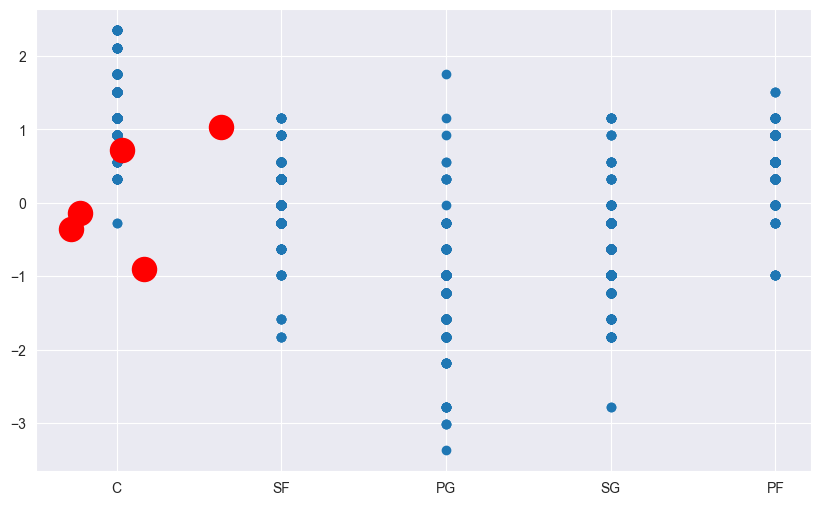

C:\Users\djjay\AppData\Local\Temp\ipykernel_3880\3023130641.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = pred_y
C:\Code\Git\vt_AdvML\paper\src\lib\modelCommon.py:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_conc = df_conc.append(


ZeroDivisionError: division by zero

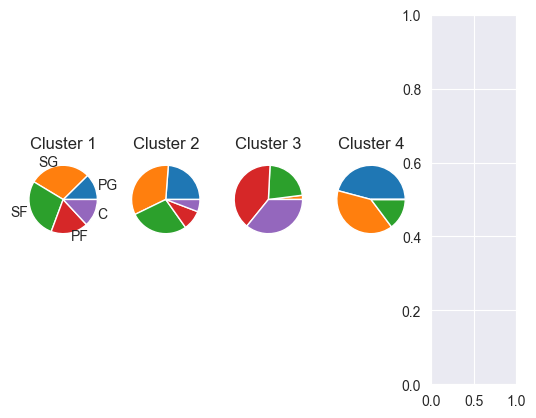

In [178]:
'''
Program Control flags and constants fr operation.
 Please customize these values to produce the outputs desired.

-- Flags --
DEBUG   - Simple program run. Run only one decade of information. Most
            commonly used for debugging purposes.
LOAD_MODEL_DATA - Determine if the program should create the data used in
                    modeling (see the program's two inputs) or load an already
                    created .csv file from a previous run when this flag was
                    set to FALSE.
                    (REQUIRES two input .csv files - see file header)
OUTPUT_FILES_FLAG - Decide if reference DataQualityReports and other csvs for
                     independent validation should be created.
INCLUDE_POS - Flag to specify if models should consider a player's
                Position (PG, SF, C, etc) in modeling.
THREE_POSITION_FLAG - Specify how many positions to consider. The traditional
                        five positions {PG, SG, SF, PF, C} or condensed
                        summarized positions {G, F, C}

-- File Paths --
PLAYER_PATH - File path to a dataset with player height and weight
DATA_PATH - File path to a dataset with player statistics

-- Numerics and Lists --
YEARS   - List of numeric Pairs stating what year range for a model to consider.
DQR_NON_NUMERIC_COLUMNS - List from DATA_PATH of features that are not Numeric.
                            (Used by the DataQualityReport class)
REQ_GAMES - Numeric. Filter to remove players that don't play enough games
              in a season.
REG_MIN - Numeric. Filter to remove players that don't play enough
               'minutes per game' in a season.
'''
DEBUG = False
LOAD_MODEL_DATA = True

PLAYER_PATH = "../data/input/Players.csv"
#DATA_PATH = "../data/input/Seasons_Sta ts.csv" #1950-2017
DATA_PATH = "../data/input/Seasons_Stats_1950_2022.csv"  #1950-2022
OUTPUT_FILES_FLAG = False

HIERARCHICAL = False
SOM = False
KMEANS = True

REQ_GAMES = 20
REQ_MIN = 10
INCLUDE_POS = True
THREE_POSITION_FLAG = False

DQR_NON_NUMERIC_COLUMNS = ['Unnamed: 0', 'Player', 'Tm', 'Pos',
                           'blanl', 'blank2']

YEARS = [[1971, 1980],
         [1981, 1990],
         [1991, 2000],
         [2001, 2010],
         [2011, 2020]]

if DEBUG:
    YEARS = [YEARS[0], YEARS[1]]


##########################
################
##########################

'''
** Program Execution starts HERE **
'''
# Load your own correctly formatted csv file to reduce computation time.
if LOAD_MODEL_DATA:
    df_data = pd.read_csv("../data/ref/Season_Stats_MODEL_{}-{}.csv".format(
                            YEARS[0][0], YEARS[len(YEARS)-1][1]))
else:
    df_data = dp.initialDataModification(PLAYER_PATH, DATA_PATH, YEARS,
                                          REQ_GAMES, REQ_MIN,
                                          THREE_POSITION_FLAG,
                                          DQR_NON_NUMERIC_COLUMNS,
                                          OUTPUT_FILES_FLAG)

# Create Cluster Metric dataframe placeholder to collect all metrics
df_metrics_hierarchy = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])
df_metrics_som = pd.DataFrame(columns=['Years', 'CHS', 'SC', 'DBI'])

for YEAR in YEARS:
    df_year = df_data[(df_data['Year'] >= YEAR[0])
                         & (df_data['Year'] <= YEAR[1])]

    if HIERARCHICAL:
        metrics = hc.hierarchicalClustering(df_year, [YEAR[0], YEAR[1]],
                                            INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_hierarchy.loc[len(df_metrics_hierarchy)] = metrics
        print("** Model1 (Divisive Clustering): COMPLETE\n")

    if SOM:
        metrics = som(df_year, [YEAR[0], YEAR[1]],
                      INCLUDE_POS, THREE_POSITION_FLAG)
        df_metrics_som.loc[len(df_metrics_som)] = metrics
        print("** Model2 (SOM Clustering): COMPLETE\n")

    if KMEANS:
        metrics = runKmeans(df_year, [YEAR[0], YEAR[1]],
                      INCLUDE_POS, THREE_POSITION_FLAG)
        #df_metrics_som.loc[len(df_metrics_som)] = metrics
        print("** Model3 (SOM KMeans): COMPLETE\n")


df_metrics_hierarchy.to_csv(
    '../data/output/MODEL_Metrics_Hierarchy_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS)-1][1]),
    index=False)

df_metrics_som.to_csv(
    '../data/output/MODEL_Metrics_som_{}-{}.csv'.format(
        YEARS[0][0], YEARS[len(YEARS)-1][1]),
    index=False)



